In [1]:
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter
from scipy import stats as sts

import matplotlib.pyplot as plt

# Introduction & Background

In this project, we will model the trusted Mauna Loa Observatory data set, a timeseries of atmospheric C02 concentration data from the Mauna Loa Observatory, Hawaii, collected since 1958 on a daily basis. 

In [3]:
url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'
raw_data = pd.read_csv(url, skiprows=44, names = ["Date", "ppm"])
raw_data["Date"] = pd.to_datetime(raw_data["Date"])

raw_data["Years"] = ((raw_data.Date - raw_data.Date[0]).dt.days) / 365.25

In [4]:
# count dates where date is 1960
count_1960 = raw_data.Date.isin(pd.date_range(start='1960-01-01', end='1960-12-31'))

sum(count_1960)

# weeks in year
weeks_in_year = 52

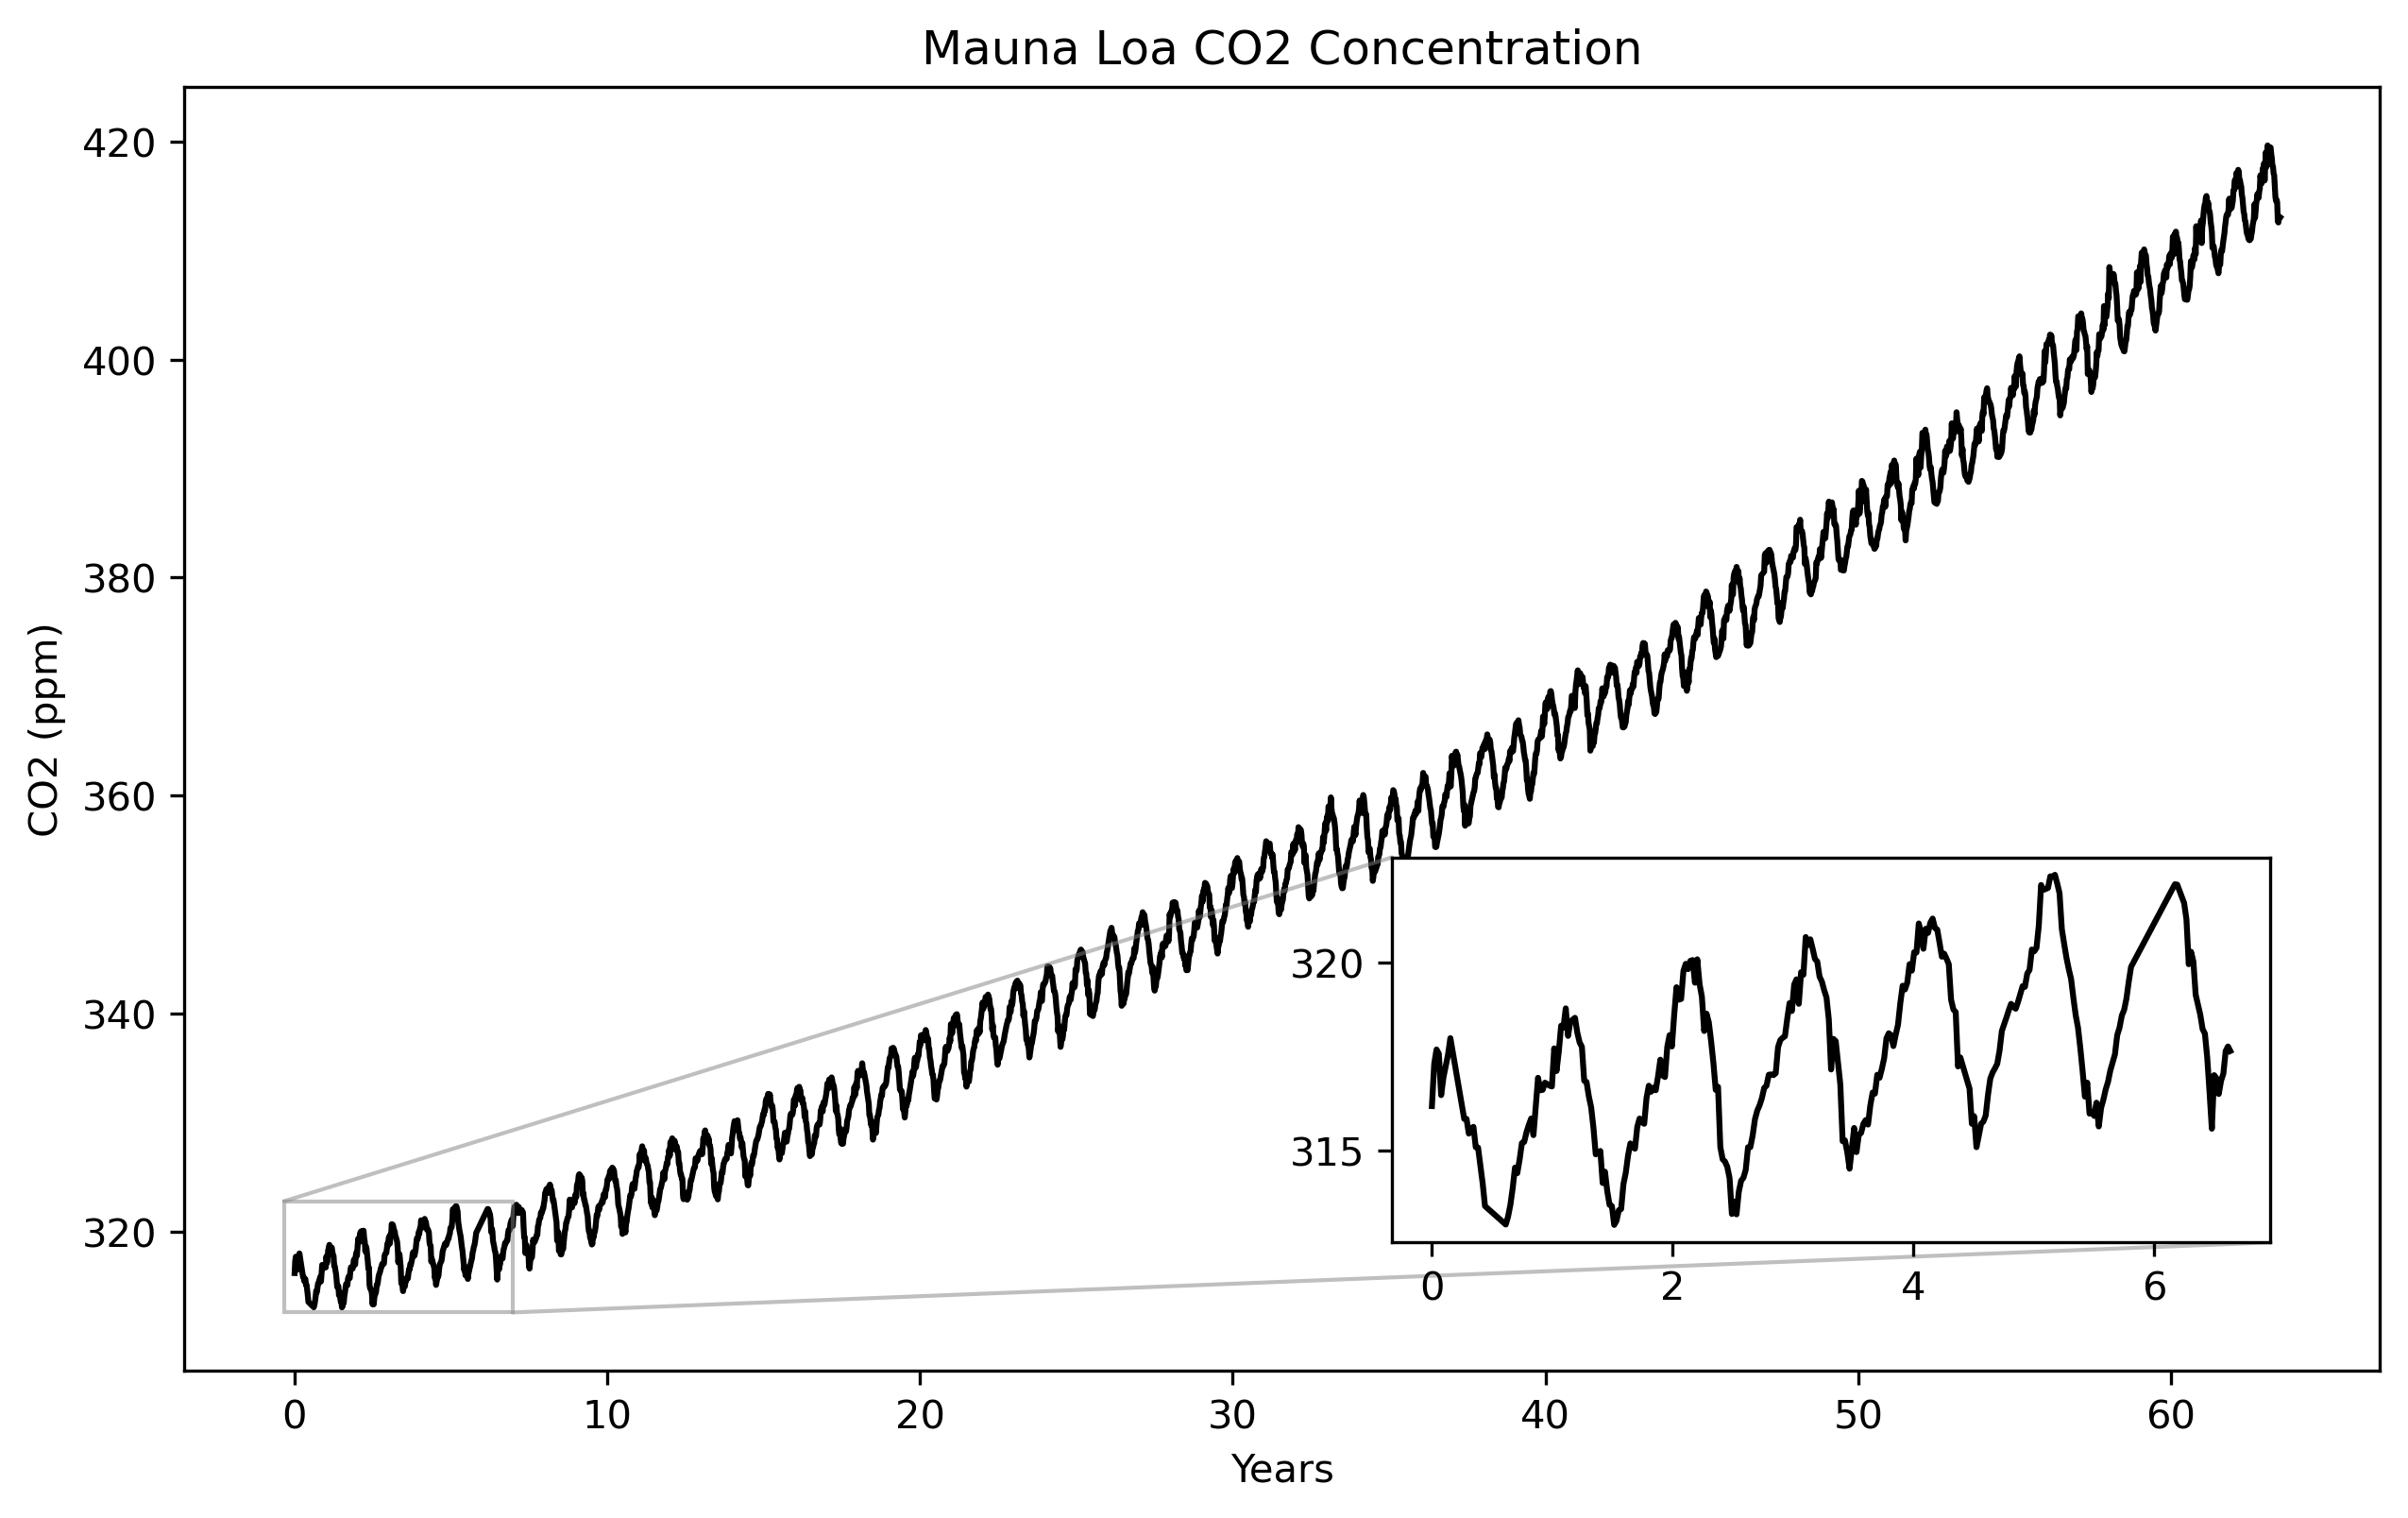

In [129]:
fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)
ax.plot(raw_data["Years"], raw_data["ppm"], color="black")
ax.set_xlabel("Years")
ax.set_ylabel("CO2 (ppm)")
ax.set_title("Mauna Loa CO2 Concentration")

# Add a small box that zooms into a narrow of interest
axins = ax.inset_axes([0.55, 0.1, 0.4, 0.3])
axins.plot(raw_data["Years"][:300], raw_data["ppm"][:300], color="black")
# indicate zoom
ax.indicate_inset_zoom(axins)
plt.show()

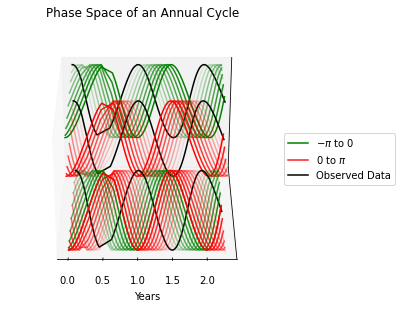

In [131]:
# Plot this in 3d
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

t = 40
m = 0
b = -80

ax.plot(
    raw_data["Years"][:100], 
    np.cos(2*np.pi*raw_data["Years"])[:100], 
    [t]*100,
    color="black")
pies = np.linspace(-np.pi, 0, 10)
for pi in pies:
    ax.plot(
        raw_data["Years"][:100], 
        np.cos(2*np.pi*raw_data["Years"] + pi)[:100],
        [t]*100,
        color="green",
        alpha = np.abs(pi/np.pi))
    # label the first one
    if pi == pies[0]:
        ax.plot(
            raw_data["Years"][:100].iloc[-1], 
            np.cos(2*np.pi*raw_data["Years"] + pi)[:100].iloc[-1],
            t,
            color="green",
            label = "$-\pi$ to 0",
            alpha = np.abs(pi/np.pi))


# Plot this at a lower level
plt.plot(
    raw_data["Years"][:100], 
    np.cos(2*np.pi*raw_data["Years"])[:100], 
    [m]*100,
    color="black")

pies = np.linspace(0, np.pi, 10)
for pi in pies:
    ax.plot(
        raw_data["Years"][:100], 
        np.cos(2*np.pi*raw_data["Years"] + pi)[:100],
        [m]*100,
        color="red",
        alpha = np.abs(pi/np.pi))
    # label the last one
    if pi == pies[-2]:
        ax.plot(
            raw_data["Years"][:100].iloc[-2], 
            np.cos(2*np.pi*raw_data["Years"] + pi)[:100].iloc[-2],
            m,
            label = "0 to $\pi$",
            color="red",
            alpha = np.abs(pi/np.pi))
    

# Plot this at a lower level
ax.plot(
    raw_data["Years"][:100], 
    np.cos(2*np.pi*raw_data["Years"])[:100], 
    [b]*100,
    color="black",
    label = "Observed Data")

pies = np.linspace(-np.pi, np.pi, 20)
for pi in pies:
    # if pi is less than 0, then plot in yellow
    if pi < 0:

        ax.plot(
            raw_data["Years"][:100], 
            np.cos(2*np.pi*raw_data["Years"] + pi)[:100],
            [b]*100,
            color="green",
            alpha = np.abs(pi/np.pi))
    else:
        ax.plot(
            raw_data["Years"][:100], 
            np.cos(2*np.pi*raw_data["Years"] + pi)[:100],
            [b]*100,
            color="red",
            alpha = np.abs(pi/np.pi))


# Set x axis label
ax.set_xlabel('Years')

# Remove grid 
ax.grid(False)
# remove z axis 
ax.w_zaxis.set_major_locator(plt.NullLocator())
# Remove y axis
ax.w_yaxis.set_major_locator(plt.NullLocator())
# Set title
ax.set_title("Phase Space of an Annual Cycle")
# show label
ax.legend()
# change 3d aspect ratio
ax.azim = -90
# move legend to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

This figure, known as the Keeling curve, is far from innocuous: it suggests a rising trend in CO2, decoupled from the rhythms of seasonal trends. This is haunting, quantitative evidence for anthropogenic climate change. Prior (no pun intended) to specifying the model, we will first perform a brief exploratory analysis and split the data into training and test sets.

# Data Preparation

We perform two simple transformations on the dataset. First, the Datetime object was converted to a 'Years' float, counting the number of years since 1958. Second, the 'CO2' column was converted to a float. 

## Exploratory Analysis

To motivate how to model the data, we will first break up the trend into components. 

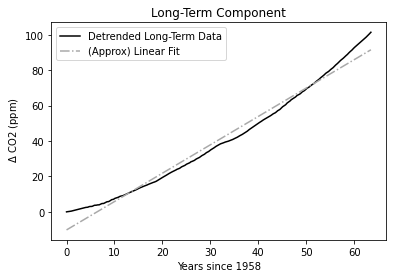

In [393]:
# detrend raw data.ppm
detrended_data = raw_data.copy()
detrended_data["ppm"] = savgol_filter(detrended_data["ppm"], 365, 3)

plt.plot(
    raw_data.Years, 
    detrended_data.ppm - detrended_data.ppm[0], 
    color="black",
    label = "Detrended Long-Term Data")

m,c = np.polyfit(raw_data.Years, detrended_data.ppm - detrended_data.ppm[0], 1)

plt.plot(
    raw_data.Years,
    m*raw_data.Years + c,
    color = "darkgrey",
    linestyle = "-.",
    label = "(Approx) Linear Fit",
)

# label
plt.legend()
# add labels
plt.xlabel("Years since 1958")
plt.ylabel(r" $\Delta $ CO2 (ppm)")
plt.title("Long-Term Component")

# save figure
plt.savefig("long_term_component.png", dpi = 300)

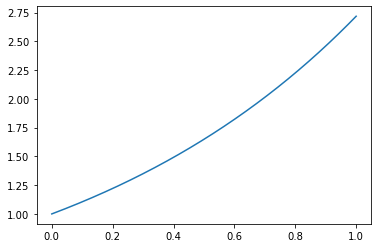

In [47]:
mod = raw_data.Years/raw_data.Years.max()

plt.plot(mod, np.exp(mod))

Long term trend. 

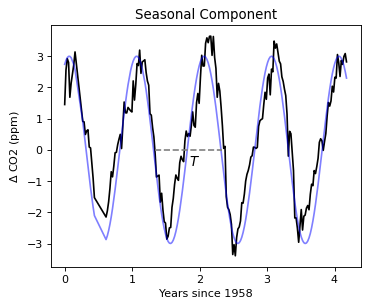

In [395]:
# large figure
fig = plt.figure(figsize=(5, 4), dpi = 80)
# Oscillations over first few years
model  = np.polyfit(raw_data.Years, raw_data.ppm, 2)
predicted = np.polyval(model, raw_data.Years)

plt.plot(raw_data.Years[:200],(raw_data.ppm - predicted)[:200], color="black", label = "Seasonal Trend in Data")
# label axes and title
plt.xlabel("Years since 1958")
plt.ylabel(r"$ \Delta $ CO2 (ppm)")
plt.title("Seasonal Component")

# overlay a single sine curve
# weeks in a year
weeks = 52
start = weeks
plt.plot(
    raw_data.Years[: 200],
    3*np.sin(2*np.pi*raw_data.Years[ :200] + 20),
    color="blue",
    alpha = 0.5,
    label = "Sine Curve")

# A line marking one wavelength
plt.plot(
    raw_data.Years[start: start + weeks],
    [0]*weeks,
    color="grey",
    linestyle = "--",
    )

# annotate previos line
plt.annotate(
    "$T$",
    xy = (raw_data.Years[start] + 0.5, -0.5),
    size = "large",)

# place legend outside figure at the bottom
#plt.legend(loc='lower left', bbox_to_anchor=(0, -0.2))
plt.show()

Seasonal component. Amplitude seems to be around 3, and the period about 1 year.

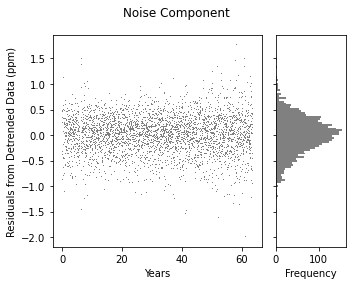

In [398]:
# Discernible noise? Correlated Noise or White?
# Does noise change over years?

# Subplot with 2 panels, right is smaller than left
# right panel is smaller than left panel
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    figsize=(5, 4),
    sharey = True,
    gridspec_kw={'width_ratios': [3, 1]},
    tight_layout =True)

#smooth predicted
seasonal = (raw_data.ppm - predicted)
smooth_predicted = savgol_filter(seasonal, 25, 3)
residuals = (seasonal - smooth_predicted)

# Plot difference between seasonal and smoothed predicted on left
ax1.plot(
    raw_data.Years, 
    residuals,
    ',',
    markersize=5,
    color="grey")
# Plot residuals histogram on right
ax2.hist(
    residuals, 
    bins=100, 
    color="grey",
    orientation="horizontal",)
# label axes
ax1.set_xlabel('Years')
ax1.set_ylabel('Residuals from Detrended Data (ppm)')

ax2.set_xlabel('Frequency')
plt.suptitle("Noise Component")

# save figure
plt.savefig("noise_component.png")


Fine-grained white noise is the third component. Homoscedastic, and notably Gaussian-distributed. We will make use of this property in the third proposed model using a Gaussian process.

Uncorrelated noise is often a combination of measurement noise and "noise" as we know it: ocean winds creating a flux in CO2 readings, light day-to-day miscalibrations, and so on.


# Modeling

MCMC is a Markov Chain Monte Carlo (MCMC) algorithm for Bayesian estimation of the posterior distribution of a parameter. In this project, we will use the `pystan` package to perform the MCMC. Code for stan is provided in the technical appendix.

## Linear-Cosine Model

$$ p(\mathbf{x}|\theta) = \prod_{t=1}^{n} p(x_t|\theta) = \prod_{t=1}^{n} N(c_0 + c_1 t + c_2\cos{(2\pi (t + c_3))}, c_4^2) $$

$t$ is the time index, where time is measured in Years since data started to be collected, $x$ is the CO2 concentration, and $y$ is the modeled CO2 concentration.

$ \theta = \{c_0, c_1, c_2, c_3, c_4\}$

$ n = 3242$

Parameters 1 to 4 are layered to form the overall linear-cosine trend, while the last parameter accounts for homoscedastic noise.

1. Parameter $c_0$: Historical $\text{CO}_2$ Levels. In the absence of variability. 

2. Parameter $c_1$: Long-Term Trend.

3. Parameter $c_2$: Seasonal.

4. Parameter $c_3$: Phase Shift. $\omega = \frac{2\pi}{T)$ 

5. Parameter $c_4$: Random Fluctuations away from the layered trend. 

In the literature, this is known as the uniform *pie*er

Posterior Predictive Distribution:
![](/Users/andrevacha/Desktop/cs146/Final Project/linco.png)

## Exponential-Cosine Model





 $$ c_1 e^{c_2 t} $$
 
 c1 rescales
 c2 captures the trend in the data
     This will need small values of c2 to capture the trend, so the priors will need to be adjusted to contain most of the mast below 1. 
t is the time index. With the 'years since' index used earlier, the search becomes ill defined (e^60 = 1e26 !). To keep the search bounded, we will map the year index to a fraction of year index, such that it is bounded between 0 and 1.

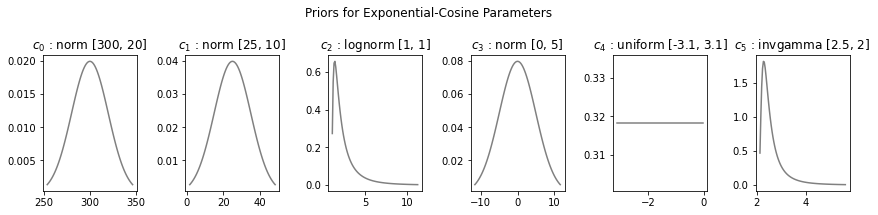

In [33]:
# Subplot of 5 priors
lc_priors = [
    sts.norm(300,20), 
    sts.norm(0,5), 
    sts.norm(0,5), 
    sts.uniform(-np.pi,np.pi),
    sts.invgamma(2.5,2),
]

le_priors = [
    sts.norm(300,20), 
    sts.norm(25,10), 
    sts.lognorm(1,1), 
    sts.norm(0,5),
    sts.uniform(-np.pi,np.pi),
    sts.invgamma(2.5,2),
]

# round args
def round_args(args):
    ars = [0,0]
    for i, arg in enumerate(args):
        ars[i] = round(arg, 1)
    return ars
# A function that plots prior pdfs on subplots
def plot_prior(prior, ax, i):
    # calculate range of x values using cdf
    x = np.linspace(prior.ppf(0.01), prior.ppf(0.99), 100)
    ax.plot(x, prior.pdf(x), color="grey")
    # set title based on prior name
    ax.set_title(f'$c_{i}$ : {prior.dist.name} {round_args(prior.args)}')

def plot_priors(priors, title = "Priors for Exponential-Cosine Parameters"):
    fig, axs = plt.subplots(
        1, len(priors),
        figsize=(12, 3),
        sharey = False,
        tight_layout =True)

    # iterate through axes
    for i, ax in enumerate(axs.flatten()):
        # plot priors
        plot_prior(priors[i], ax, i)

    # add an overall title 
    fig.suptitle(title)

plot_priors(le_priors)


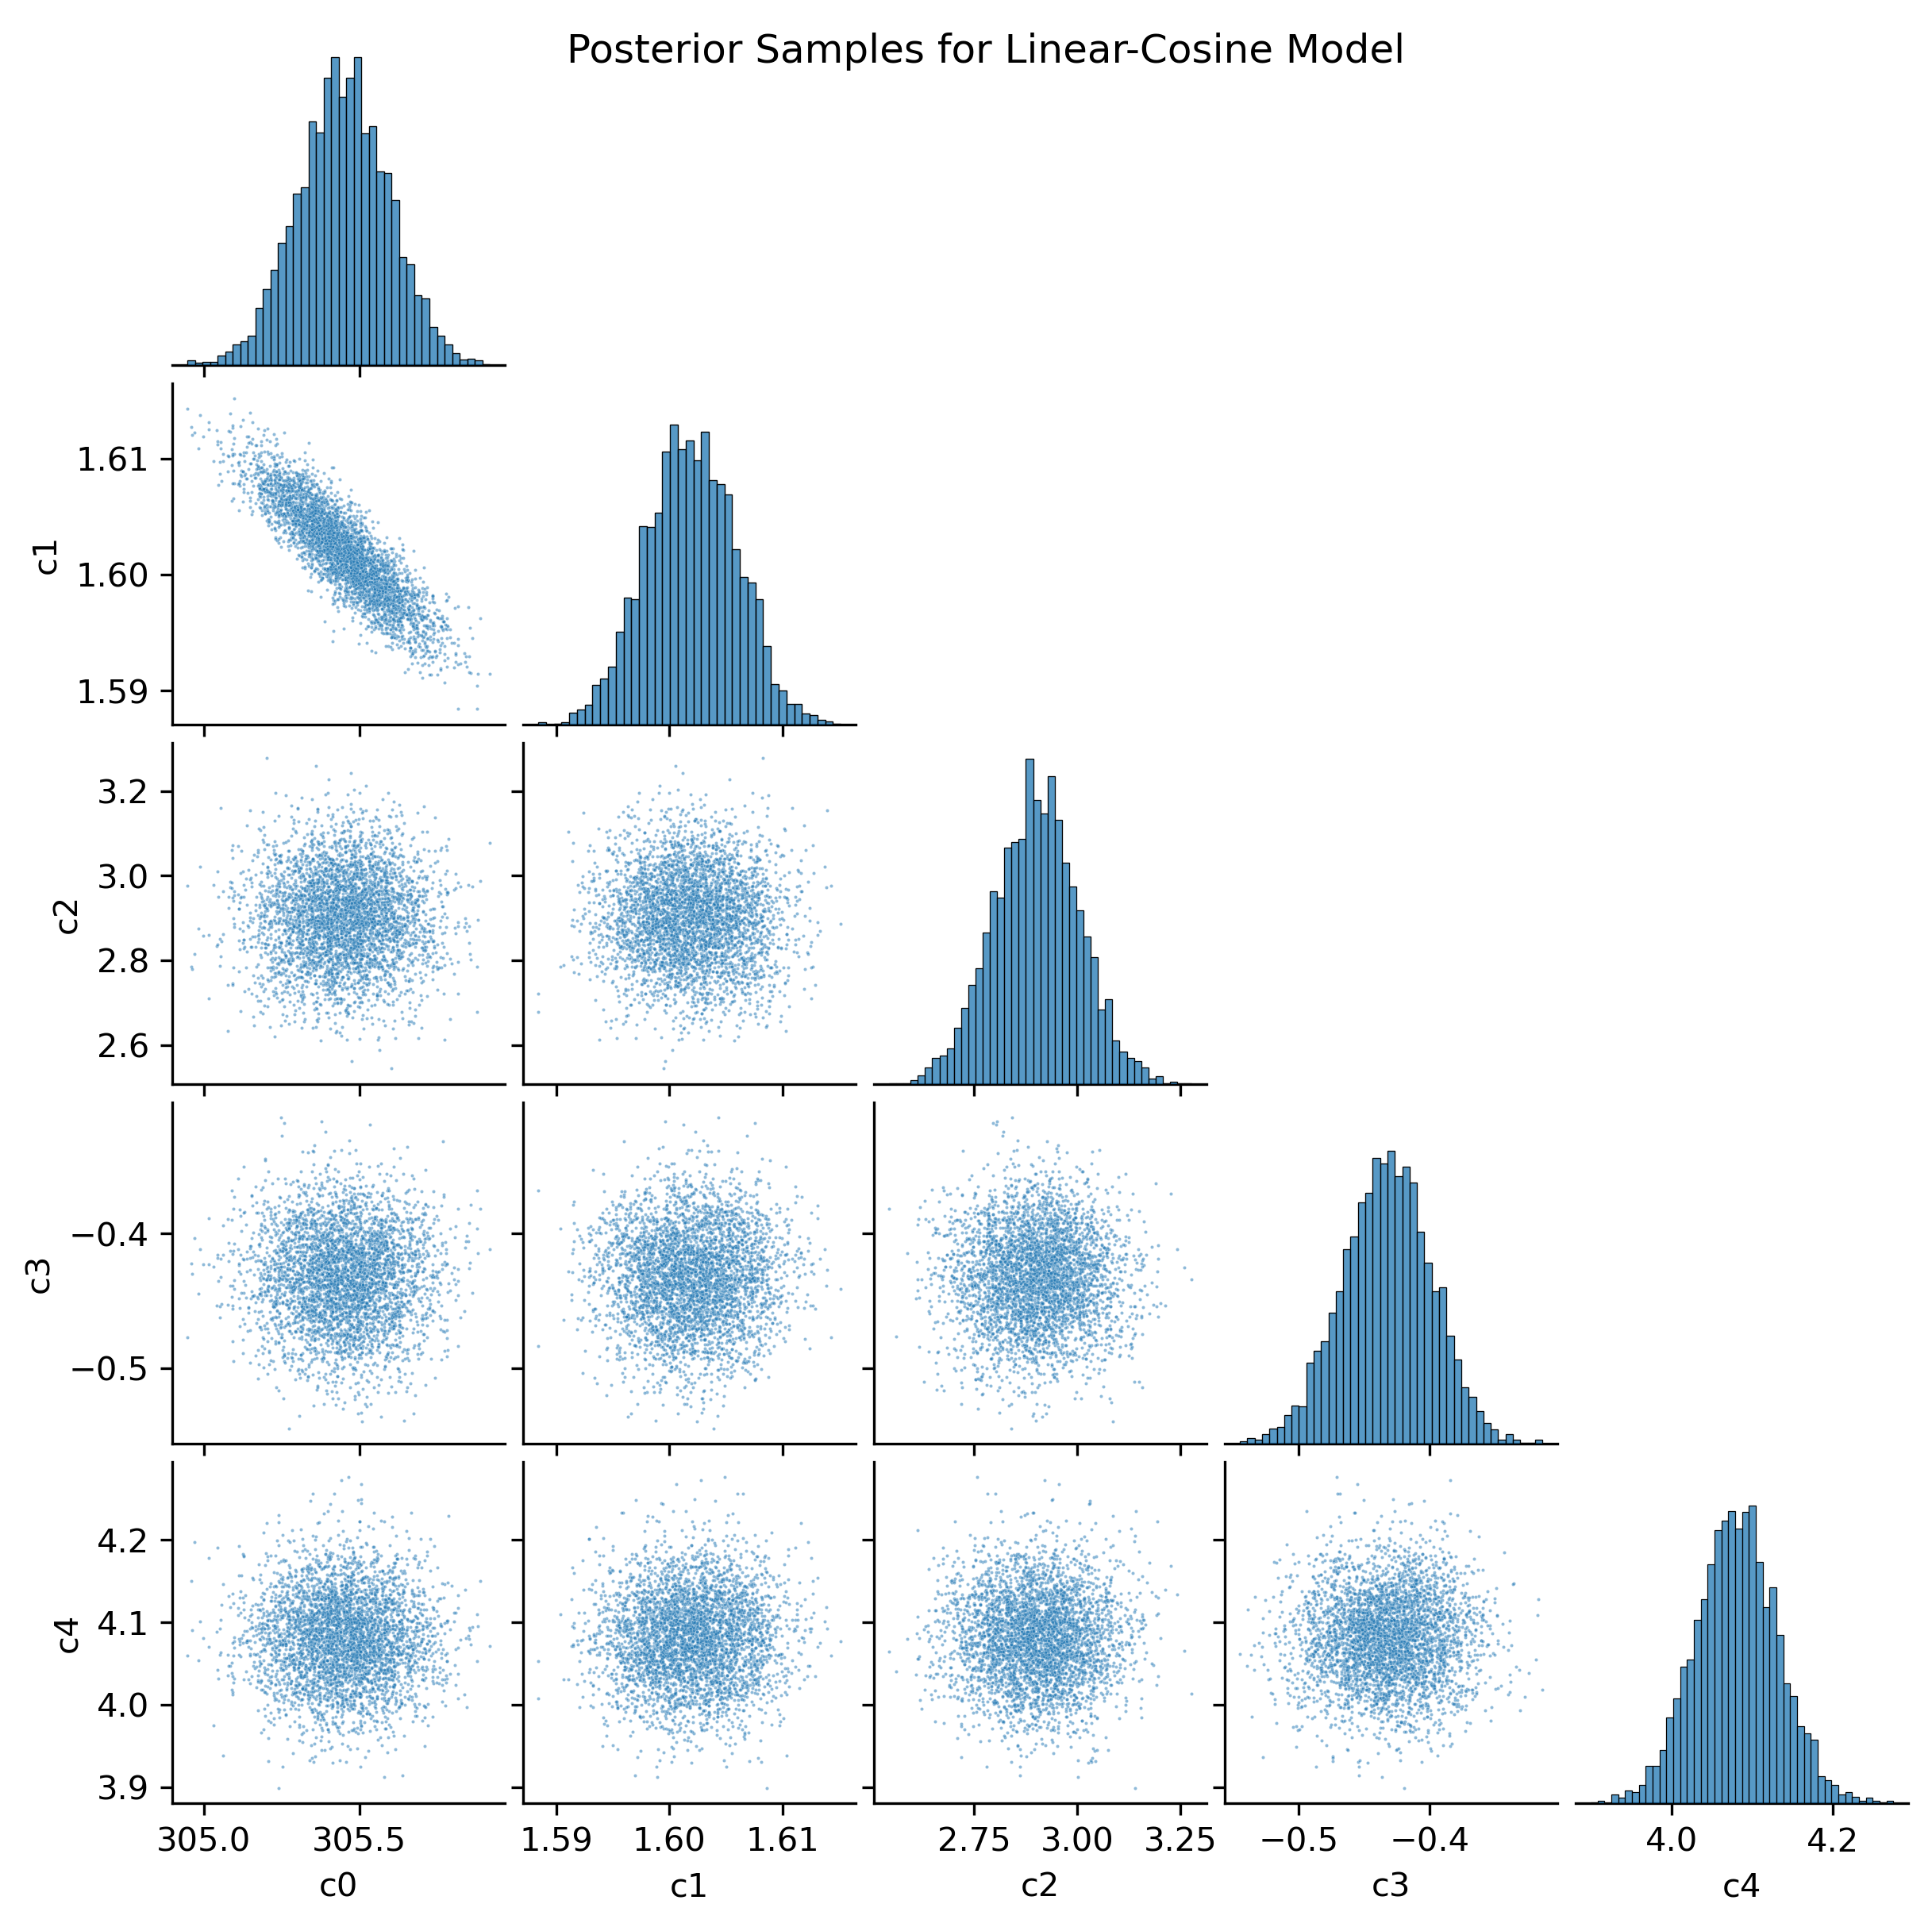

In [383]:
import seaborn as sns


toy_results = pd.read_csv('toy_results.csv')

g = sns.pairplot(toy_results,
            vars=["c0", "c1", "c2", "c3", "c4"],   
            markers = "o",    
            palette="Greys",
            plot_kws={"s": 1, "alpha": 0.5}, 
            corner = True,
)

g.fig.set_dpi(300)
# set title
g.fig.suptitle("Posterior Samples for Linear-Cosine Model")
g.fig.set_size_inches(8,8)

# save 
g.fig.savefig("ecosine_pair.png")

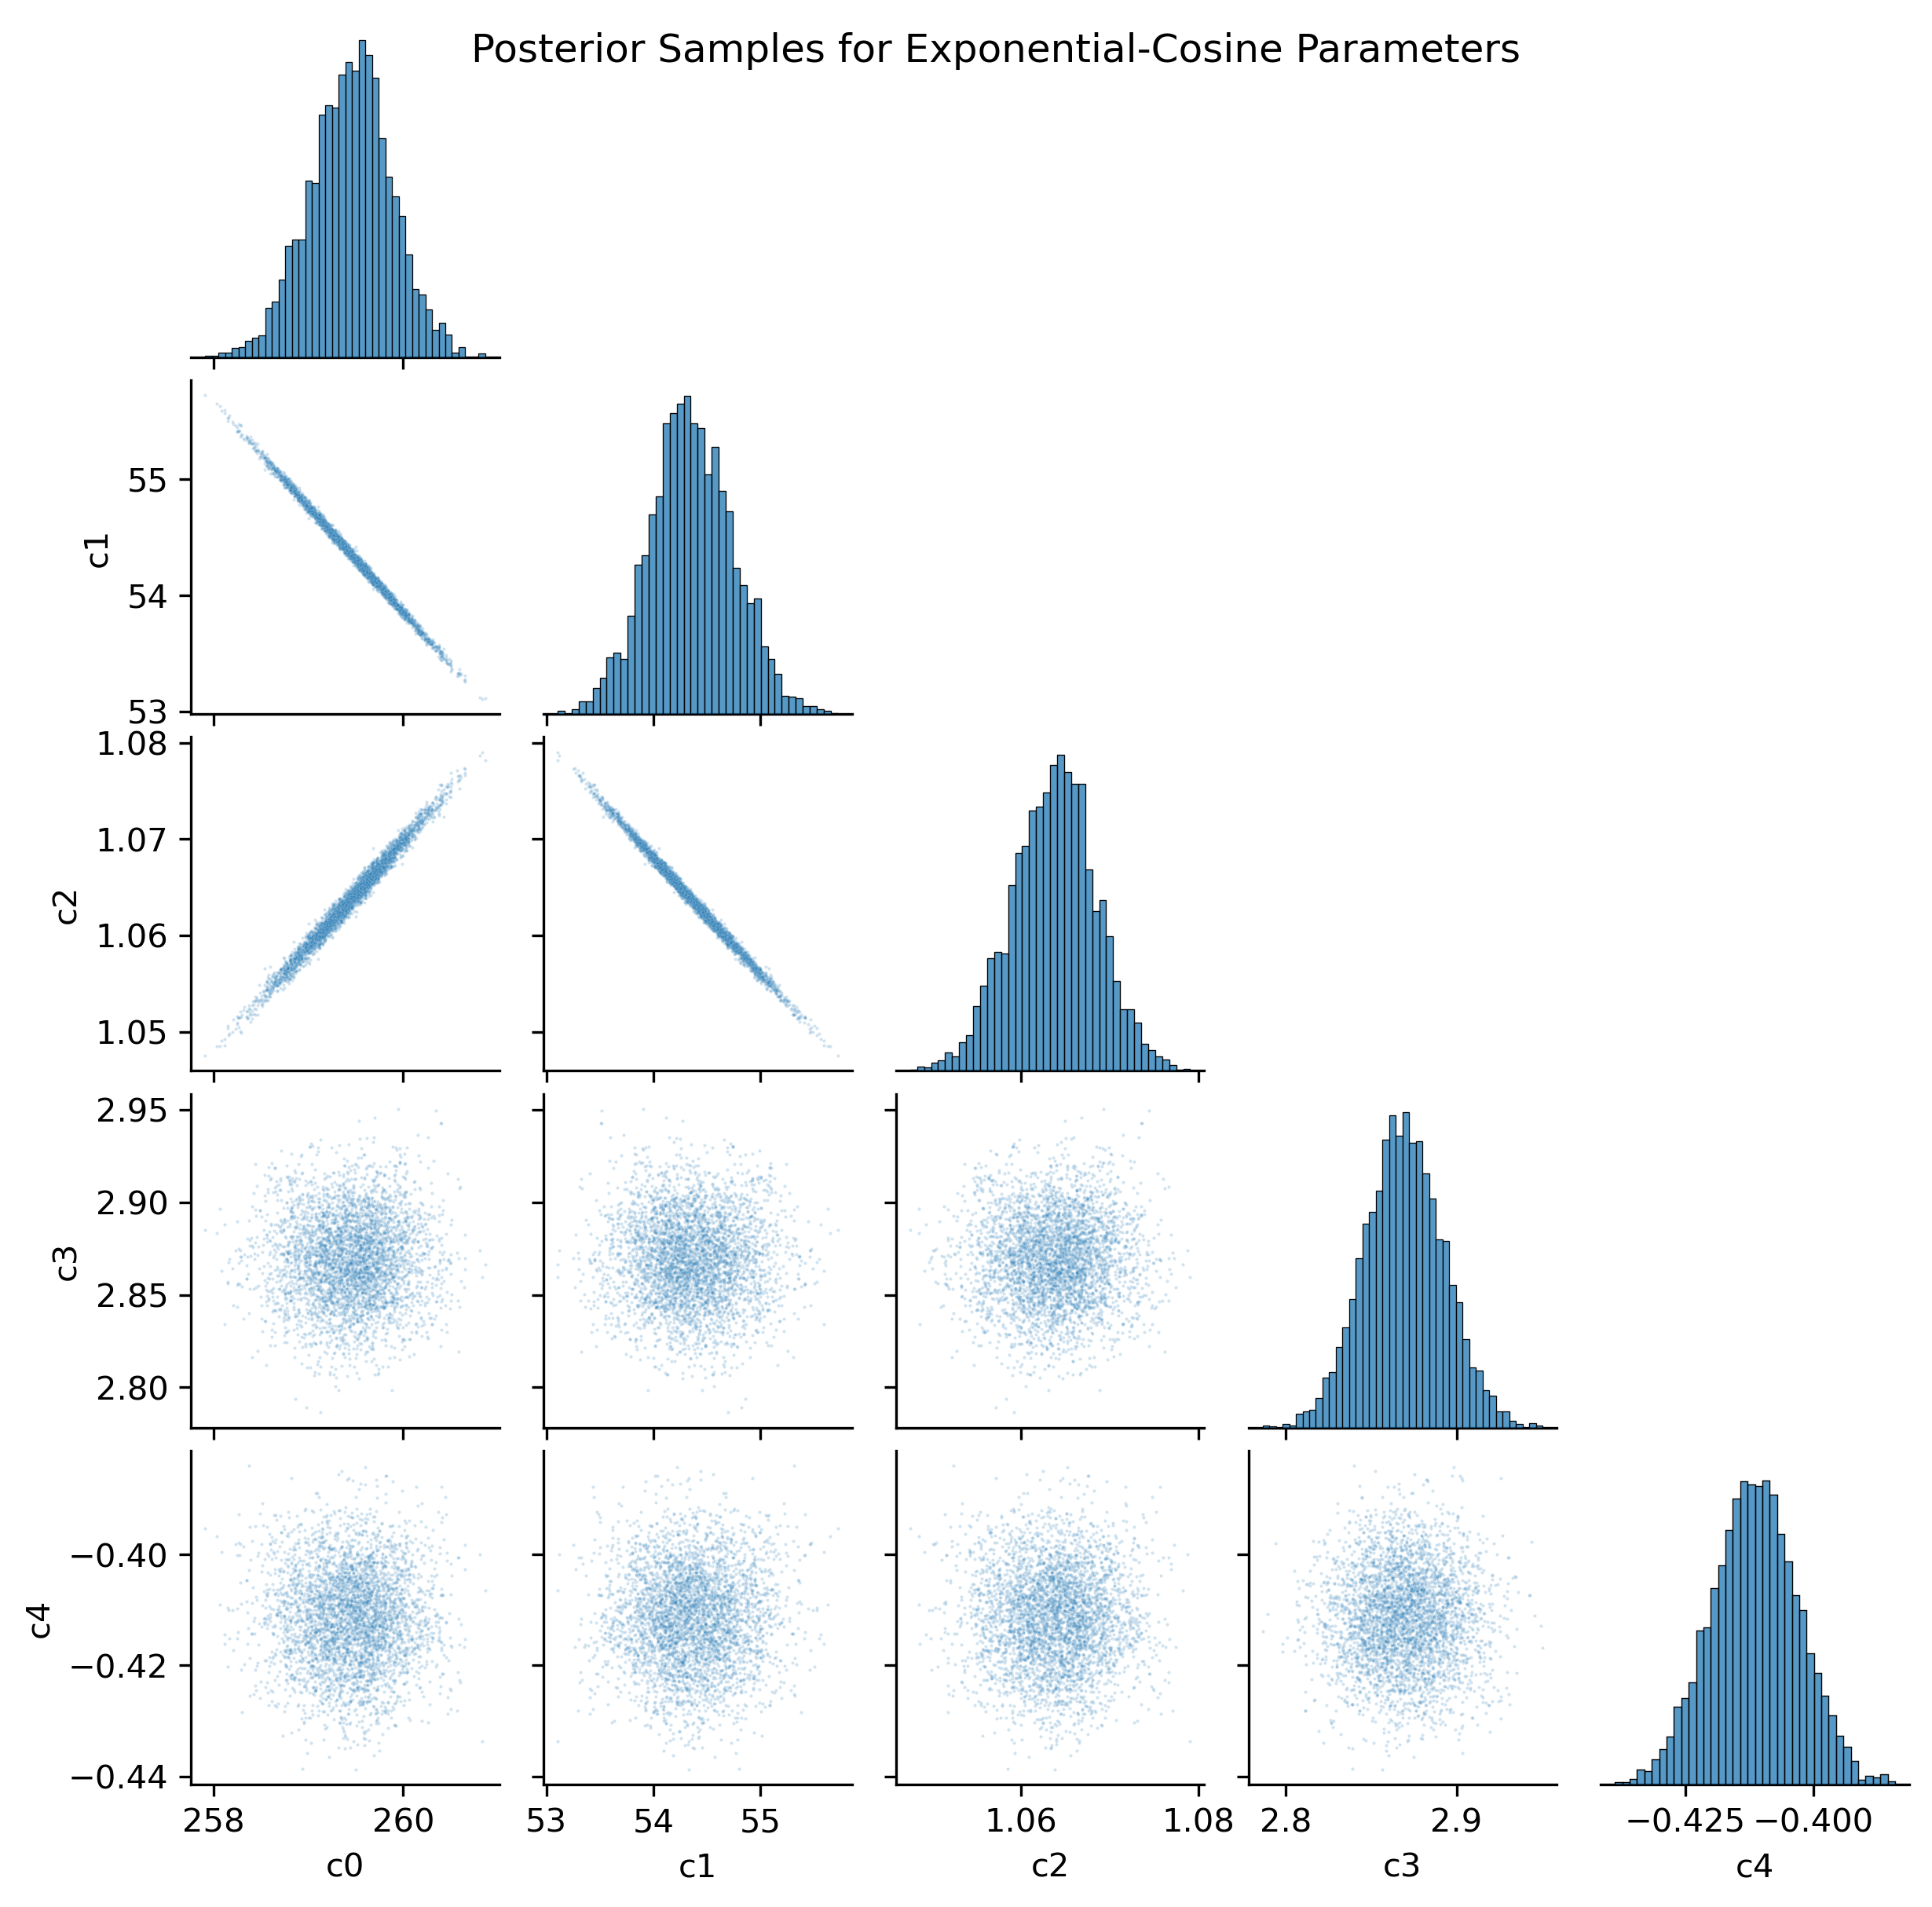

In [381]:

g = sns.pairplot(exp_results,
            vars=["c0", "c1", "c2", "c3", "c4"],   
            markers = "o",    
            palette="Greys",
            plot_kws={"s": 1, "alpha": 0.2}, 
            corner = True,
)

# set title
g.fig.suptitle("Posterior Samples for Exponential-Cosine Parameters")
g.fig.set_size_inches(8,8)
# set high dpi
g.fig.set_dpi(300)
# save figure
g.savefig("exp_results.png")

In [385]:
# import lcosine_pair.png and convert to gray scale
# convert to gray scale
from PIL import Image

img = Image.open("exp_results.png")
img = img.convert("L")
# save as new image
img.save("ecosine_pair_gray.png")

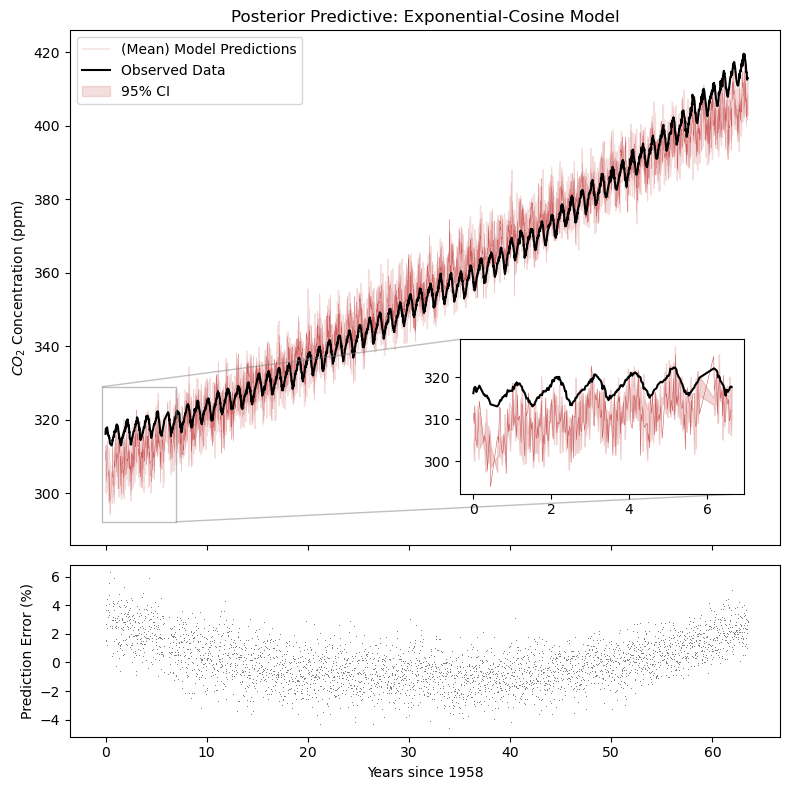

In [391]:
def get_percentile(res, percentile = 50, params =['c0','c1','c2','c3','c4']):
  return res.apply(lambda x: np.percentile(a = x, q = percentile)).loc[params,]

t = raw_data.Years.values

def get_preds(res, percentile=50):
  samples = get_percentile(res, percentile)

  pred = np.random.normal(
      samples['c0'] + samples['c1']*t + \
      samples['c2']*np.cos(2*np.pi*t + samples['c3']), samples['c4'])
  
  return pred

def plot_post_pred(res, get_preds = get_preds):

    fig, axs = plt.subplots(2,1, 
                            figsize = (8,8),
                            sharex = True,
                            gridspec_kw={'height_ratios': [3, 1]},
                            tight_layout =True,
                            dpi = 100)


    upper = get_preds(res, 97.5)
    lower = get_preds(res, 2.5)
    pred = get_preds(res)

    t = raw_data['Years']

    axs[0].plot(
        t, 
        pred, 
        color = "indianred",
        alpha = 1,
        linewidth = 0.2,
        label = "(Mean) Model Predictions")

    axs[0].fill_between(
        t, 
        lower, 
        upper,
        color = 'indianred',
        alpha = 0.2,
        label = "95% CI")

    axs[0].plot(
        raw_data["Years"],
        raw_data["ppm"], 
        alpha = 1,
        color = 'black',
        label = "Observed Data")



    axs[0].legend()


    # Add a small box that zooms into a narrow of interest
    axins = axs[0].inset_axes([0.55, 0.1, 0.4, 0.3])
    n = 300

    axins.plot(
        t[:n],
        pred[:n], 
        alpha = 1,
        linewidth = 0.4,
        color="indianred")


    axins.fill_between(
        t[:n],
        lower[:n],
        upper[:n], 
        alpha = 0.25,
        color="indianred")



    axins.plot(
        raw_data["Years"][:n],
        raw_data["ppm"][:n], 
        color="black")

        
    # indicate zoom
    axs[0].indicate_inset_zoom(axins, label = "Detail")


    # Plot relative error
    axs[1].plot(
        t,
        (raw_data["ppm"] - pred)/raw_data["ppm"] * 100,
        ',',
        color = 'grey'
    )


    axs[0].set_ylabel('$ CO_2 $ Concentration (ppm)')
    axs[1].set_ylabel('Prediction Error (%)')
    axs[1].set_xlabel("Years since 1958")
    axs[0].set_title("Posterior Predictive: Exponential-Cosine Model")

    plt.show()


plot_post_pred(toy_results)

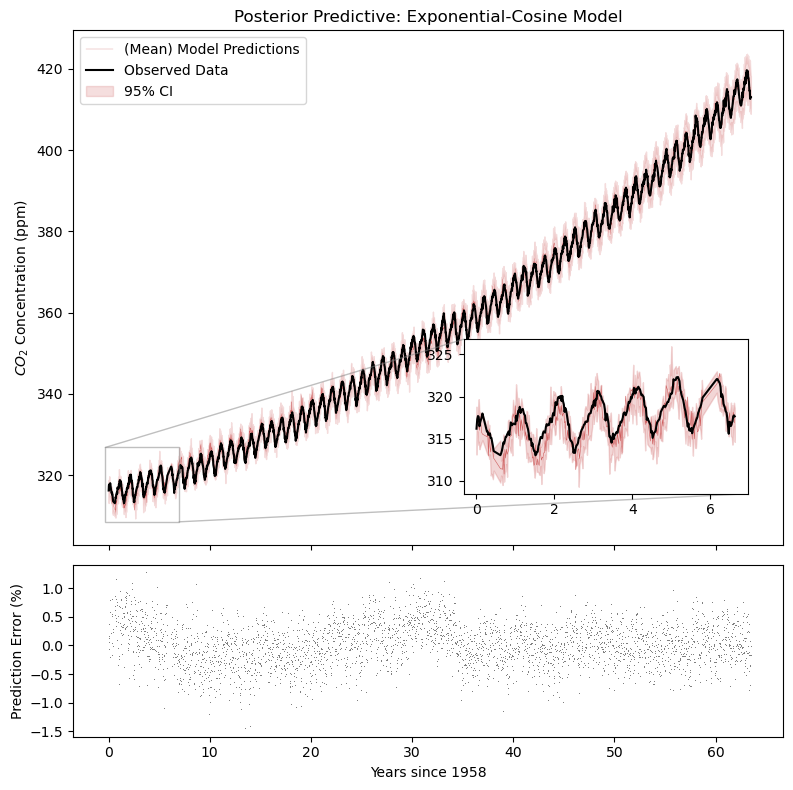

In [392]:
exp_results = pd.read_csv('exp_results.csv')

mod = raw_data.Years/raw_data.Years.max()

def get_exp_preds(res, percentile=50, mod = mod, t = t):
  samples = get_percentile(res, percentile, params=['c0','c1','c2','c3','c4','c5'])

  pred = np.random.normal(
      samples['c0'] + samples['c1']*np.exp(samples['c2']*mod) + \
      samples['c3']*np.cos(2*np.pi*t + samples['c4']), samples['c5'])
  
  return pred

plot_post_pred(exp_results, get_exp_preds)

# Results

## Comparison



In [274]:
get_percentile(toy_results, percentile = 2.5, params =['c0','c1','c2','c3','c4'])


def replicate_data(results, params = ['c0','c1','c2','c3','c4', 'c5'], test_stats = [np.mean]):

  params = results.loc[:,params]
  stats = np.zeros((params.shape[0], len(test_stats)))

  # iterate each set of samples
  for i in range(params.shape[0]):
    sample = params.iloc[i]

    # generate simulated/replicated data from the model
    replicated_data = exp_likelihood(sample)

    for t in range(len(test_stats)):
      stat = test_stats[t]
      try:
        stats[i, t] = stat(replicated_data)
      except IndexError:
        stats[i] = stat(replicate_data)

  # apply stats to actual data
  true_stats = np.zeros((len(test_stats),))
  for t in range(len(test_stats)):
    stat = test_stats[t]
    true_stats[t] = stat(raw_data.ppm.values)

  return stats, true_stats


def exp_likelihood(sample, mod = None, t = None):

  if mod is None:
    mod = raw_data.Years/raw_data.Years.max()

  if t is None:
    t = raw_data.Years
  
  
  pred = np.random.normal(
      sample['c0'] + sample['c1']*np.exp(sample['c2']*mod) + \
      sample['c3']*np.cos(2*np.pi*t + sample['c4']), sample['c5'])
  
  return pred




DatetimeIndex(['1958-03-30', '1958-04-06', '1958-04-13', '1958-04-20',
               '1958-04-27', '1958-05-04', '1958-05-11', '1958-05-18',
               '1958-05-25', '1958-06-01',
               ...
               '2059-10-26', '2059-11-02', '2059-11-09', '2059-11-16',
               '2059-11-23', '2059-11-30', '2059-12-07', '2059-12-14',
               '2059-12-21', '2059-12-28'],
              dtype='datetime64[ns]', length=5310, freq='W-SUN')

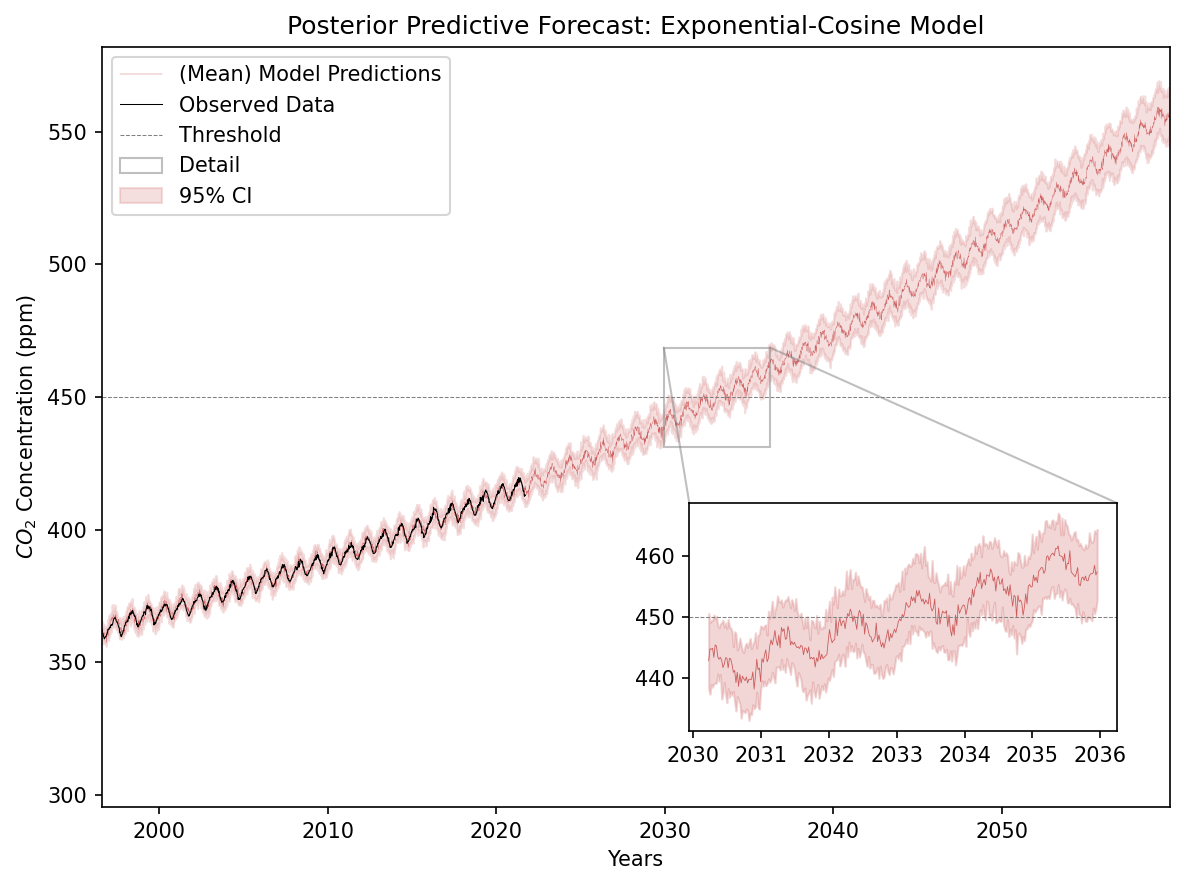

In [362]:
# predict for next 20 years

# extend raw data Date to 2050
raw_data_ext = raw_data.copy()

# create a weekly daterange to start of 2060
daterange =  pd.date_range(
    start = raw_data_ext.Date.min(),
    end = '2060-01-01',
    freq = 'W')

t = (daterange - daterange.min()).days/365.25
mod = t/raw_data.Years.max()


# generate simulated/replicated data from the model

fig, axs = plt.subplots(1,1, 
                            figsize = (8,6),
                            sharex = True,
                            
                            tight_layout =True,
                            dpi = 150)


pred = get_percentile(exp_results, percentile = 50, params =['c0','c1','c2','c3','c4', 'c5'])
pred = exp_likelihood(pred, mod = mod, t = t)

# plot 95% interval
lower = get_percentile(exp_results, percentile = 2.5, params =['c0','c1','c2','c3','c4', 'c5'])
upper = get_percentile(exp_results, percentile = 97.5, params =['c0','c1','c2','c3','c4', 'c5'])
lower = exp_likelihood(lower, mod = mod, t = t)
upper = exp_likelihood(upper, mod = mod, t = t)



axs.plot(
    daterange, 
    pred, 
    color = "indianred",
    alpha = 1,
    linewidth = 0.2,
    label = "(Mean) Model Predictions")

axs.fill_between(
    daterange, 
    lower, 
    upper,
    color = 'indianred',
    alpha = 0.2,
    label = "95% CI")

axs.plot(
    raw_data["Date"],
    raw_data["ppm"], 
    alpha = 1,
    color = 'black',
    linewidth = 0.5,
    label = "Observed Data")





# Add a small box that zooms into a narrow of interest
axins = axs.inset_axes([0.55, 0.1, 0.4, 0.3])
# n is where crosses 450 ppm
n = np.where(upper > 450)[0][0]
e = n + 300

axins.plot(
    daterange[n:e],
    pred[n:e], 
    alpha = 1,
    linewidth = 0.4,
    color="indianred")


axins.fill_between(
    daterange[n:e],
    lower[n:e],
    upper[n:e], 
    alpha = 0.25,
    color="indianred")

    
# indicate zoom
axs.indicate_inset_zoom(axins, label = "Detail")

axs.set_ylabel('$ CO_2 $ Concentration (ppm)')
axs.set_xlabel("Years")
axs.set_title("Posterior Predictive Forecast: Exponential-Cosine Model")

# set xlim to the zoomed in region
axs.set_xlim(daterange[2000], daterange.max())

# A thin red axhline at 450 ppm 
axs.axhline(y = 450, color = "grey", linewidth = 0.5, label = "Threshold", linestyle = '--')
axins.axhline(y = 450, color = "grey", linewidth = 0.5, label = "Threshold", linestyle = '--')

axs.legend()


plt.show()

# make xticks years 


In [373]:
# getting bounds on when threshold is crossed
idxs = np.where(lower > 450)[0][0],  np.where(pred > 450)[0][0], np.where(upper > 450)[0][0], 

# in daterange where are idxs
for i in idxs: 
    print(daterange[i])


2034-03-26 00:00:00
2032-04-11 00:00:00
2030-03-24 00:00:00


In [246]:
test_stats = [np.mean, np.std, np.median, np.min, np.max]

stats, true_stats = replicate_data(exp_results, test_stats = test_stats)

In [237]:
# calculate IQR

def iqr(x):
 return np.percentile(x, 75, axis = 0) - np.percentile(x, 25, axis = 0)


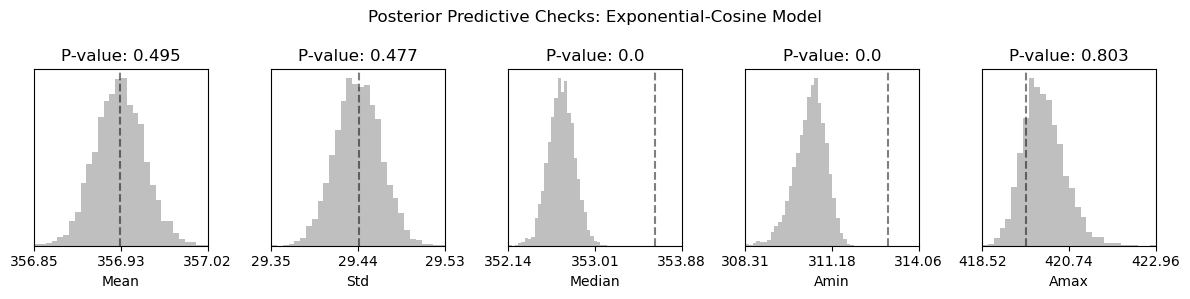

In [360]:
# plot hist of each column in stats
fig, axs = plt.subplots(
    1, len(test_stats),
    figsize=(12, 3),
    dpi = 100,
    tight_layout =True)

# iterate axs
for i in range(len(test_stats)):
    # convert column to float16 for readability

    axs[i].hist(
        stats[:,i],
        color="grey",
        density = True,
        bins = 30,
        alpha=0.5)
    
    # fewer x ticks
     # remove yaxis
    axs[i].set_yticks([])

    # add each true stat as vertical line

    axs[i].axvline(
        true_stats[i],
        color = 'black',
        linestyle = '--',
        alpha = 0.5)

    # p val is fraction of stats that are greater than true stat
    p_val = (stats[:,i] > true_stats[i]).sum()/stats.shape[0]
    axs[i].set_title(f'P-value: {round(p_val,3)}')

    # set title, first letter capital
    axs[i].set_xlabel(
        test_stats[i].__name__[0].upper() + test_stats[i].__name__[1:]
    )

    xlow =  min(true_stats[i] - 1.5*iqr(stats[:,i]), stats[:,i].min())
    xhigh = max(true_stats[i] + 1.5*iqr(stats[:,i]), stats[:,i].max())

    # set xlim based on position of true stat
    axs[i].set_xlim(
       xlow,
       xhigh
    )

    axs[i].set_xticks(np.linspace(xlow, xhigh, 3))
    # round xlabel to 2 decimal places
    axs[i].set_xticklabels(
        [round(x, 2) for x in axs[i].get_xticks()])


    # set overall title
    fig.suptitle(
        "Posterior Predictive Checks: Exponential-Cosine Model"
    )


In [110]:
def get_percentile(res, percentile = 50, params =['c0','c1','c2','c3','c4']):
  return res.apply(lambda x: np.percentile(a = x, q = percentile)).loc[params,]


array([305.50211112])

In [63]:
def get_ame(true, preds):
  return np.sum(np.abs((true - preds)))/len(true)


get_ame(raw_data["ppm"], get_exp_preds(exp_results)), get_ame(raw_data["ppm"], get_preds(toy_results))


(1.101129825992592, 4.589656040512457)

# Technical Appendix

<Axes:>

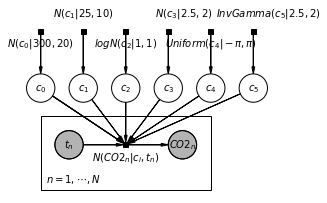

In [21]:
import daft

# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
#pgm.add_node("alpha", r"$\alpha$", 0.5, 2, fixed=True)

#pgm.add_plate([1.5, 2, 1, 1.5], label=r"$i = 1, \cdots, 4$", shift=0)


# Observed variable.
pgm.add_node("t", r"$t_n$", 1, 1, observed=True)

# Data.
pgm.add_node("co2", r"$CO2_n$", 3, 1, observed=True)

pgm.add_node(
    "N", 
    r"$N(CO2_{n} | c_{i}, t_n)$",
    2, 1, 
    shape = 'rectangle', 
    fixed = True,
    offset = (0, - 20))

for i in range(6):
    pgm.add_node(f"c{i}", f"$c_{i}$", 0.5 + i*0.75, 2)
    pgm.add_edge(f"c{i}", "N")

# Add hyperpriors


# Add in the edges.
pgm.add_edge("t", "N")
pgm.add_edge("c0", "N")
pgm.add_edge("N", "co2")



pgm.add_node(
        f"N{1}",
        r"$N(c_{0} | 300, 20)$",
        0.5, 3,
        shape = 'rectangle', 
        fixed = True,
        offset = (0, - 20))


pgm.add_node(
        f"N{2}",
        r"$N(c_{1} | 25, 10)$",
        0.5 + 0.75, 3,
        shape = 'rectangle', 
        fixed = True,
        offset = (0, 10))

pgm.add_node(
        f"N{3}",
        r"$logN(c_{2} | 1, 1)$",
        0.5 + 2*0.75, 3,
        shape = 'rectangle', 
        fixed = True,
        offset = (0, - 20))

pgm.add_node(
        f"N{4}",
        r"$N(c_{3} | 2.5, 2)$",
        0.5 + 3*0.75, 3,
        shape = 'rectangle', 
        fixed = True,
        offset = (15, 10))

pgm.add_node(
        f"N{5}",
        r"$Uniform(c_{4} | -\pi, \pi)$",
        0.5 + 4*0.75, 3,
        shape = 'rectangle', 
        fixed = True,
        offset = (0, - 20))

pgm.add_node(
        f"N{6}",
        r"$InvGamma(c_{5} | 2.5, 2)$",
        0.5 + 5*0.75, 3,
        shape = 'rectangle', 
        fixed = True,
        offset = (15, 10))



for i in range(1,7):
        pgm.add_edge(f"N{i}", f"c{i-1}")


# And a plate.
pgm.add_plate([0.5, 0.5, 3, 1], label=r"$n = 1, \cdots, N$", shift=-0.3)

# Render and save.
pgm.render()


Loss functions
Mean absolute error on the test set

$$ MAE = \sum_{t=1}^{T}|y_t - \hat{y}_t| $$


Although there is a very large literature (rightly so) on such parametric modelling methods, there are many scenarios in which we have little, or no, prior knowledge regarding appropriate models to use. We may, however, have seemingly less specific domain knowledge; for example, we may know that our observations are visible examples from an underlying process that is smooth, continuous and variations in the function take place over characteristic time scales (not too slowly yet not so fast) and have typical amplitude

[[1.         0.60653066]
 [0.60653066 1.        ]]


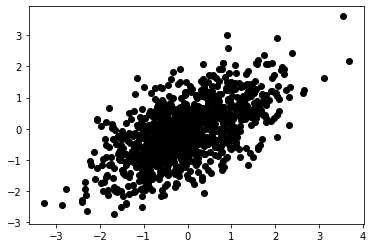

In [11]:
# a function that generates a random sample from a multivariate gaussian
def generate_sample(mu, sigma, n=1):
    """
    Generate a random sample from a multivariate gaussian.
    """
    return np.random.multivariate_normal(mu, sigma, n)

# a sqaured exponential covariance function
def cov_sqexp(x, y, l=1, s=1):
    """
    Covariance function for a squared exponential.
    """
    return l**2. * np.exp(-0.5 * ((x - y) / s)**2.)

x = np.array([0,-1])
y = np.array([0,-1])


# make a covariance kernel matrix n x n
n = 2
cov_mat = np.zeros((n, n))

# fill the covariance matrix
for i in range(n):
    for j in range(n):
        cov_mat[i, j] = cov_sqexp(x[i], x[j], 1, 1)

print(cov_mat)


n = 1000

# generate mu and sigma 
mu = np.array([0, 0])
sigma = cov_mat

# store samples
samples = generate_sample(mu, sigma, n = 1000)
plt.scatter(samples[:,0], samples[:,1], color = "black")

# n repeating 1s and n repeating 2s
t = np.array([1] * n + [2] * n)
# make column of samples flat
y = np.concatenate((samples[:,0].T, samples[:,1].T))

#plt.scatter(t,y)

# plot histogram of each sample column on same plot
#plt.hist(samples[:,0], bins = 20, color = "red", alpha = 0.5)
#plt.hist(samples[:,1], bins = 20, color = "blue", alpha = 0.5)
